1. Pobierz bazę danych dotyczącą śmiertelnych interwencji policji w USA, a następnie wczytaj ją do obiektu DataFrame.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('fatal-police-shootings-data.csv')
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


2. Przekształć tabelę w taki sposób, aby wskazywała zestawienie jednocześnie liczby ofiar interwencji według rasy (‘race’) oraz tego, czy wykazywały one oznaki choroby psychicznej (‘signs_of_mental_illness’).

In [2]:
summary = df.pivot_table(index='race', columns="signs_of_mental_illness", values='id', aggfunc='count', fill_value=0)
summary

signs_of_mental_illness,False,True
race,,
A,69,24
B,1114,184
H,745,157
N,64,14
O,37,11
W,1763,713


3. Za pomocą Map, Applymap lub Apply dodaj do tego zestawienia kolumnę wskazującą jaki odsetek ofiar interwencji wykazywało oznaki choroby psychicznej dla każdej z ras. Odpowiedz, która z nich charakteryzuje się największym odsetkiem znamion choroby psychicznej podczas interwencji.

In [3]:
summary["percentage_mental_illness"] = summary[True] / summary.sum(axis=1) * 100

max_race = summary["percentage_mental_illness"].idxmax()
max_percentage = summary["percentage_mental_illness"].max()
summary["percentage_mental_illness"] = summary["percentage_mental_illness"].apply(lambda x: round(x, 2))

summary

signs_of_mental_illness,False,True,percentage_mental_illness
race,,,
A,69,24,25.81
B,1114,184,14.18
H,745,157,17.41
N,64,14,17.95
O,37,11,22.92
W,1763,713,28.80


In [4]:
print(f"Rasa z największym odsetkiem ofiar z oznakami choroby psychicznej: {max_race} ({max_percentage:.2f}%)")

Rasa z największym odsetkiem ofiar z oznakami choroby psychicznej: W (28.80%)


4. Dodaj kolumnę oznaczającą dzień tygodnia, w którym doszło do interwencji. Zlicz interwencje według odpowiedniego dnia tygodnia. Następnie stwórz wykres kolumnowy, tak aby dni tygodnia były uszeregowane od poniedziałku do niedzieli.

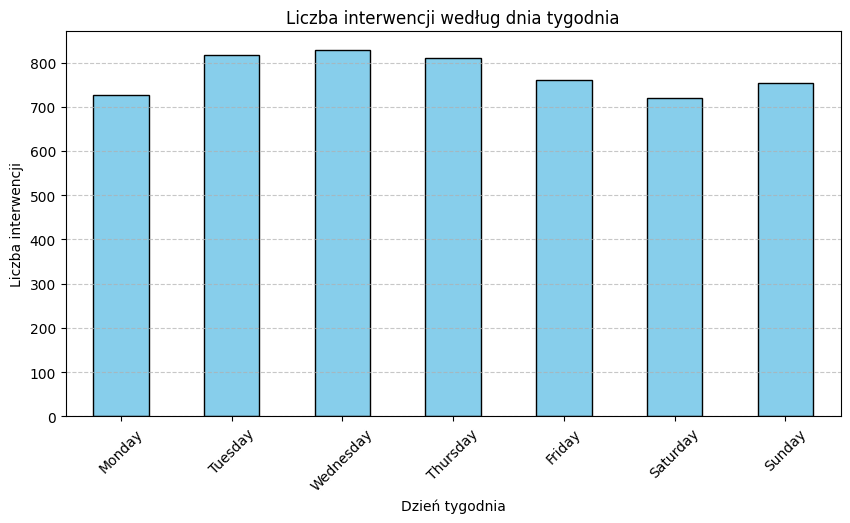

In [5]:
import matplotlib.pyplot as plt

df["date"] = pd.to_datetime(df["date"])
df["day_of_week"] = df["date"].dt.day_name()

days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

day_counts = df["day_of_week"].value_counts().reindex(days_order, fill_value=0)

#Tworzenie wykresu
plt.figure(figsize=(10, 5))
day_counts.plot(kind="bar", color="skyblue", edgecolor="black")

plt.xlabel("Dzień tygodnia")
plt.ylabel("Liczba interwencji")
plt.title("Liczba interwencji według dnia tygodnia")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

5. Wczytaj do projektu dane dotyczące populacji w poszczególnych stanach USA oraz dane dotyczące skrótów poszczególnych stanów. Połącz te bazy danych w taki sposób, aby móc policzyć do ilu incydentów w bazie dotyczącej śmiertelnych interwencji doszło w przeliczeniu na 1000 mieszkańców każdego ze stanów.

In [6]:
#pobieranie infrmacji o populacji i skrótach stanów

def load_flatten_html(url_or_path, table_index=0):
    df_list = pd.read_html(url_or_path)
    df = df_list[table_index]

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    return df

df_states_population = load_flatten_html("https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population", table_index=0)
df_states_abbr = load_flatten_html("https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations", table_index=1)

In [7]:
df_states_population.columns

Index(['Rank in states & territories, 2020',
       'Rank in states & territories, 2010', 'State',
       'Census population, April 1, 2020 [1][2]',
       'Census population, April 1, 2010 [1][2]',
       'Percent change, 2010–2020 [note 1]', 'Absolute change, 2010-2020',
       'Total seats in the U.S. House of Representatives, 2023–2033',
       'Census population per electoral vote [note 2]',
       'Census population per House seat',
       'Percent of the total U.S. population, 2020 [note 3]'],
      dtype='object')

In [8]:
df_states_abbr.columns

Index(['Name', 'Status of region', 'ISO', 'ANSI', 'ANSI', 'USPS', 'USCG',
       'GPO', 'AP', 'Other abbreviations'],
      dtype='object')

In [ ]:
#wybieram potrzebne mi kolumny
df_states_abbr = df_states_abbr[["Name", "USPS"]].rename(columns={"Name": "state_name", "USPS": "state_abbr"})
df_states_population = df_states_population[["State", "Census population, April 1, 2020 [1][2]"]].rename(
    columns={"State": "state_name", "Census population, April 1, 2020 [1][2]": "population"}
)

In [ ]:
#łączenie tabel
df_merged = df.merge(
    df_states_population.merge(df_states_abbr, on="state_name"),
    left_on="state", 
    right_on="state_abbr"
).drop(columns=['state'])
df_merged.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,signs_of_mental_illness,threat_level,flee,body_camera,day_of_week,state_name,population,state_abbr
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,True,attack,Not fleeing,False,Friday,Washington,7705281,WA
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,False,attack,Not fleeing,False,Friday,Oregon,4237256,OR
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,False,other,Not fleeing,False,Saturday,Kansas,2937880,KS
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,True,attack,Not fleeing,False,Sunday,California,39538223,CA
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,False,attack,Not fleeing,False,Sunday,Colorado,5773714,CO


In [ ]:
#liczenie incydentów w kazdym stanie
incidents_per_state = df_merged["state_abbr"].value_counts().reset_index()
incidents_per_state.columns = ["state_abbr", "incident_count"]

In [ ]:
#obliczanie liczby incydentów na 1000 osób w populacji stanu
df_final = df_merged.merge(incidents_per_state, on="state_abbr")
df_final["incidents_per_1000"] = (df_final["incident_count"] / df_final["population"]) * 1000
df_final.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,signs_of_mental_illness,threat_level,flee,body_camera,day_of_week,state_name,population,state_abbr,incident_count,incidents_per_1000
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,True,attack,Not fleeing,False,Friday,Washington,7705281,WA,152,0.019727
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,False,attack,Not fleeing,False,Friday,Oregon,4237256,OR,88,0.020768
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,False,other,Not fleeing,False,Saturday,Kansas,2937880,KS,50,0.017019
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,True,attack,Not fleeing,False,Sunday,California,39538223,CA,799,0.020208
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,False,attack,Not fleeing,False,Sunday,Colorado,5773714,CO,195,0.033774


In [ ]:
#ustawienie kolejności kolumn
column_order = [
    "id", "name", "date", "day_of_week", "manner_of_death", "armed", "age", "gender", "race",
    "signs_of_mental_illness", "threat_level", "flee", "body_camera", "city", 
    "state_name", "state_abbr", "population", "incidents_per_1000"]

df_final = df_final[column_order]
df_final

,id,name,date,day_of_week,manner_of_death,armed,age,gender,race,signs_of_mental_illness,threat_level,flee,body_camera,city,state_name,state_abbr,population,incidents_per_1000
0,3,Tim Elliot,2015-01-02,Friday,shot,gun,53.0,M,A,True,attack,Not fleeing,False,Shelton,Washington,WA,7705281,0.019727
1,4,Lewis Lee Lembke,2015-01-02,Friday,shot,gun,47.0,M,W,False,attack,Not fleeing,False,Aloha,Oregon,OR,4237256,0.020768
2,5,John Paul Quintero,2015-01-03,Saturday,shot and Tasered,unarmed,23.0,M,H,False,other,Not fleeing,False,Wichita,Kansas,KS,2937880,0.017019
3,8,Matthew Hoffman,2015-01-04,Sunday,shot,toy weapon,32.0,M,W,True,attack,Not fleeing,False,San Francisco,California,CA,39538223,0.020208
4,9,Michael Rodriguez,2015-01-04,Sunday,shot,nail gun,39.0,M,H,False,attack,Not fleeing,False,Evans,Colorado,CO,5773714,0.033774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5411,5921,William Slyter,2020-06-13,Saturday,shot,gun,22.0,M,W,False,other,Other,False,Kansas City,Missouri,MO,6154913,0.022909
5412,5922,TK TK,2020-06-13,Saturday,shot,undetermined,NaN,M,NaN,False,attack,Not fleeing,False,San Bernardino,California,CA,39538223,0.020208
5413,5924,Nicholas Hirsh,2020-06-15,Monday,shot,gun,31.0,M,W,False,attack,Car,False,Lawrence,Kansas,KS,2937880,0.017019
5414,5926,TK TK,2020-06-16,Tuesday,shot,gun,24.0,M,NaN,False,attack,Not fleeing,False,Beach Park,Illinois,IL,12812508,0.008117


In [14]:
df_final.to_csv('fatal_incidents_population_analysis.csv', index=False)